<a href="https://colab.research.google.com/github/arunt-sjsu/deep_learning/blob/main/Assignment4/Pytorch_without_Optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The Goal of this notebook is to demonstrate pytorch based linear regression to predict 'a' from the dummy data. This notebook does not use auto differentiation primitives or optimizers and the results are eventually plotted**


In [ ]:
%matplotlib inline
import numpy as np
import torch
import pandas as pd
torch.set_printoptions(edgeitems=2, linewidth=75)

In [ ]:
df = pd.DataFrame(np.random.randn(10000, 3)*10, columns=list('xyz'))
weights = pd.DataFrame(np.random.randn(10000,1), columns=['weights_a'])
weights['weights_b'] = np.random.randn(10000,1)
weights['weights_c'] = np.random.randn(10000,1)

In [ ]:
df["a"] = 2 * weights['weights_a'] * np.square(df['x']) + 8 * weights['weights_b'] * np.power(df['y'],3) - 3 * df['z'] 
df["b"] = 3 * weights['weights_a'] * np.square(df['x']) - 5 * weights['weights_b'] * np.square(df['y']) - 2 * weights['weights_c'] * np.power(df['z'],3) 

In [ ]:
bin_labels = ['Low', 'Mid', 'High', 'Very High']
df['Level_A'] = pd.qcut(df['a'], q=4, labels=bin_labels)
df['Level_B'] = pd.qcut(df['b'], q=4, labels=bin_labels)


In [ ]:
t_c = torch.tensor(df["a"])
t_u = torch.tensor(df["x"])
t_v = torch.tensor(df["y"])
t_w = torch.tensor(df["z"])
t_un = 0.1 * t_u
t_vn = 0.1 * t_v
t_wn = 0.1 * t_w

In [ ]:
def model(t_u,t_v,t_w, w1 ,w2 ,w3, b):
    return w1 * t_u + w2 * t_v + w3 * t_w + b

In [ ]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [ ]:
w1 = torch.ones(())
w2 = torch.ones(())
w3 = torch.zeros(())
b = torch.zeros(())

t_p = model(t_u,t_v,t_w, w1 ,w2 ,w3, b)
t_p

tensor([ -8.5613, -20.4256,  ..., -11.1297,  27.1331],
       dtype=torch.float64)

In [ ]:
loss = loss_fn(t_p, t_c)
loss

tensor(9.3306e+08, dtype=torch.float64)

In [ ]:
delta = 0.1

loss_rate_of_change_w = (loss_fn(model(t_u,t_v,t_w, w1+delta ,w2+delta ,w3+delta, b), t_c) -  loss_fn(model(t_u,t_v,t_w, w1-delta ,w2-delta ,w3-delta, b), t_c)) / (2.0 * delta)

In [ ]:
learning_rate = 1e-2

w1 = w1 - learning_rate * loss_rate_of_change_w
w2 = w2 - learning_rate * loss_rate_of_change_w
w3 = w3 - learning_rate * loss_rate_of_change_w

In [ ]:
loss_rate_of_change_b = (loss_fn(model(t_u,t_v,t_w, w1 ,w2 ,w3, b + delta), t_c) - loss_fn(model(t_u,t_v,t_w, w1 ,w2 ,w3, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [ ]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  
    return dsq_diffs

In [ ]:
def dmodel_dw1(t_u, w1, b):
    return t_u

def dmodel_dw2(t_v, w2, b):
    return t_v

def dmodel_dw3(t_w, w3, b):
    return t_w

In [ ]:
def dmodel_db():
    return 1.0

In [ ]:
def grad_fn(t_u,t_v,t_w, t_c, t_p, w1,w2,w3, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw1 = dloss_dtp * dmodel_dw1(t_u, w1, b)  
    dloss_dw2 = dloss_dtp * dmodel_dw2(t_v, w2, b)  
    dloss_dw3 = dloss_dtp * dmodel_dw3(t_w, w3, b) 
    dloss_db = dloss_dtp * dmodel_db()
    return torch.stack([dloss_dw1.sum(),dloss_dw2.sum(),dloss_dw3.sum(), dloss_db.sum()])  # <1>

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u,t_v,t_w, t_c):
    for epoch in range(1, n_epochs + 1):
        w1,w2,w3, b = params

        t_p = model(t_u,t_v,t_w, w1 ,w2 ,w3, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u,t_v,t_w, t_c, t_p, w1,w2,w3, b)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u,t_v,t_w, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w1,w2,w3, b = params

        t_p = model(t_u,t_v,t_w, w1 ,w2 ,w3, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u,t_v,t_w, t_c, t_p, w1,w2,w3, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0,1.0,1.0,0.0]), 
    t_u = t_u, 
    t_v = t_v, 
    t_w = t_w, 
    t_c = t_c)

Epoch 1, Loss 933058551.305152
    Params: tensor([ -47.8684, -154.1567,  -28.9851,   -1.4370], dtype=torch.float64)
    Grad:   tensor([ 4886.8398, 15515.6681,  2998.5140,   143.7010],
       dtype=torch.float64)
Epoch 2, Loss 933072494.274284
    Params: tensor([ 5.5062,  2.6298, -5.3488, -2.6845], dtype=torch.float64)
    Grad:   tensor([ -5337.4558, -15678.6499,  -2363.6365,    124.7493],
       dtype=torch.float64)
Epoch 3, Loss 933092818.436288
    Params: tensor([ -52.4966, -156.1478,  -22.6628,   -4.0785], dtype=torch.float64)
    Grad:   tensor([ 5800.2750, 15877.7666,  1731.4022,   139.4025],
       dtype=torch.float64)
...
Epoch 10, Loss 933441173.394813
    Params: tensor([ 26.7149,  16.7272, -30.8969, -12.3943], dtype=torch.float64)
    Grad:   tensor([ -9505.0882, -18341.6359,   2734.8900,     99.8185],
       dtype=torch.float64)
Epoch 11, Loss 933526409.636708
    Params: tensor([ -74.4339, -171.8495,    3.0658,  -13.6465], dtype=torch.float64)
    Grad:   tensor([10114

tensor([ 4587.0038,  5965.4532, -3578.9408,   -52.9318],
       dtype=torch.float64)

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0,1.0,1.0,0.0]), 
    t_u = t_u, 
    t_v = t_v, 
    t_w = t_w, 
    t_c = t_c)

Epoch 1, Loss 933058551.305152
    Params: tensor([ 0.5113, -0.5516,  0.7001, -0.0144], dtype=torch.float64)
    Grad:   tensor([ 4886.8398, 15515.6681,  2998.5140,   143.7010],
       dtype=torch.float64)
Epoch 2, Loss 933031463.438662
    Params: tensor([ 0.0329, -2.0719,  0.4057, -0.0287], dtype=torch.float64)
    Grad:   tensor([ 4784.5968, 15203.7250,  2944.8925,   143.5115],
       dtype=torch.float64)
Epoch 3, Loss 933005453.648782
    Params: tensor([-0.4356, -3.5617,  0.1164, -0.0431], dtype=torch.float64)
    Grad:   tensor([ 4684.4901, 14898.0569,  2892.2167,   143.3253],
       dtype=torch.float64)
...
Epoch 10, Loss 932850172.109205
    Params: tensor([ -3.4515, -13.1846,  -1.7682,  -0.1429], dtype=torch.float64)
    Grad:   tensor([ 4039.9266, 12923.7872,  2548.6244,   142.1107],
       dtype=torch.float64)
Epoch 11, Loss 932831376.797206
    Params: tensor([ -3.8470, -14.4510,  -2.0185,  -0.1571], dtype=torch.float64)
    Grad:   tensor([ 3955.3803, 12663.9802,  2502.947

tensor([-19.5261, -66.0614, -12.9525,  -1.3784], dtype=torch.float64)

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0,1.0,1.0,0.0]), 
    t_u = t_un,
    t_v = t_vn,
    t_w = t_wn,
    t_c = t_c)

Epoch 1, Loss 933037732.609028
    Params: tensor([ -3.7033, -14.3359,  -1.8235,  -1.4337], dtype=torch.float64)
    Grad:   tensor([ 470.3340, 1533.5940,  282.3467,  143.3685], dtype=torch.float64)
Epoch 2, Loss 933011267.593982
    Params: tensor([ -8.3077, -29.3635,  -4.5966,  -2.8372], dtype=torch.float64)
    Grad:   tensor([ 460.4382, 1502.7600,  277.3168,  140.3470], dtype=torch.float64)
Epoch 3, Loss 932985856.914923
    Params: tensor([-12.8152, -44.0890,  -7.3204,  -4.2110], dtype=torch.float64)
    Grad:   tensor([ 450.7503, 1472.5464,  272.3751,  137.3893], dtype=torch.float64)
...
Epoch 10, Loss 932834176.256310
    Params: tensor([ -41.8208, -139.2029,  -25.0740,  -13.0508], dtype=torch.float64)
    Grad:   tensor([ 388.4007, 1277.4010,  240.1310,  118.3574], dtype=torch.float64)
Epoch 11, Loss 932815819.977772
    Params: tensor([ -45.6231, -151.7201,  -27.4324,  -14.2095], dtype=torch.float64)
    Grad:   tensor([ 380.2263, 1251.7207,  235.8430,  115.8628], dtype=torch.

tensor([-195.7564, -661.8330, -130.6696,  -59.9276], dtype=torch.float64)

In [ ]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0,1.0,1.0,0.0]), 
    t_u = t_un,
    t_v = t_vn,
    t_w = t_wn,
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 933037732.609028
Epoch 2, Loss 933011267.593982
Epoch 3, Loss 932985856.914923
...
Epoch 10, Loss 932834176.256310
Epoch 11, Loss 932815819.977772
...
Epoch 99, Loss 932385506.095082
Epoch 100, Loss 932385011.284776
...
Epoch 4000, Loss 932373049.328151
Epoch 5000, Loss 932373049.328151


tensor([-222.1622, -762.1946, -155.6476,  -67.9802], dtype=torch.float64)

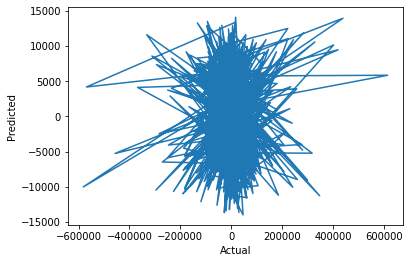

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_u,t_v,t_w, w1 ,w2 ,w3, b)

fig = plt.figure()
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(t_c.numpy(), t_p.detach().numpy())